<a href="https://colab.research.google.com/github/hydro-7/Vision-Transformers-PyTorch/blob/main/ViT(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementation of the Vision Transformer model based on the paper "An Image is Worth 16x16 Words"

References :

1) [Paper](https://arxiv.org/abs/2010.11929)

2) [Github](https://jalammar.github.io/illustrated-transformer/)

3) [Step by Step Video](https://www.youtube.com/watch?v=j3VNqtJUoz0&list=PL1468eQl9JS7K8fdyoGTAjiKwEtBGBhDx&index=2)


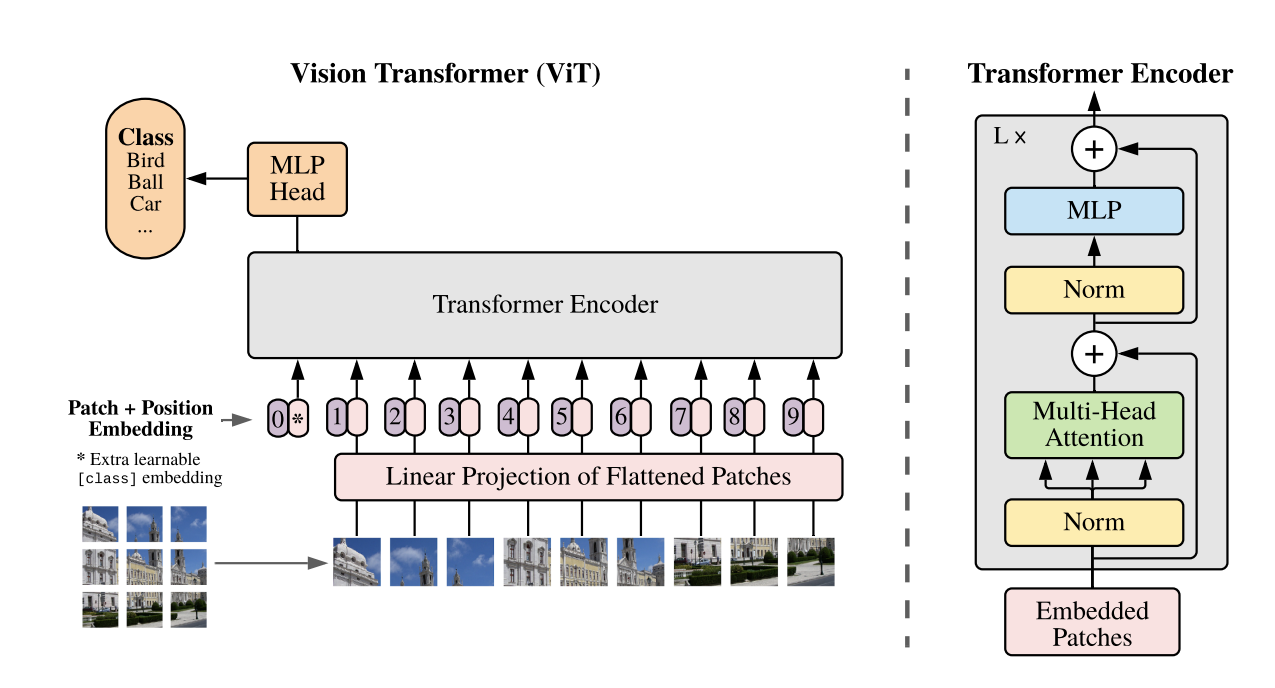



Ref : [Research Paper](https://arxiv.org/pdf/2010.11929)

In [1]:
import torch
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
from random import random
from torchvision.transforms import Resize, ToTensor
from torchvision.transforms.functional import to_pil_image

from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor

# **1. Patchification using Einops :**


In [2]:
!pip install einops

Defining the Image transformations to make them all into tensors of the same size.

In [3]:
to_tensor = [Resize((144, 144)), ToTensor()]

class Transform(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image = t(image)
        return image, target

Function to display images from the dataset.

In [4]:
def show_images(images, num_samples = 16, cols = 8):
    plt.figure(figsize=(15,8))
    idx = int(len(dataset) / num_samples)
    print(images)
    for i, img in enumerate(images):
        if i % idx == 0:
            plt.subplot(int(num_samples/cols) + 1, cols, int(i/idx) + 1)
            plt.imshow(to_pil_image(img[0]))

We use the OxfordIIITPet dataset, transforming and displaying its images.

In [5]:
dataset = OxfordIIITPet(root=".", download=True, transforms=Transform(to_tensor))

100%|██████████| 792M/792M [00:50<00:00, 15.6MB/s]


Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet


100%|██████████| 19.2M/19.2M [00:02<00:00, 8.38MB/s]


Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet


Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: .


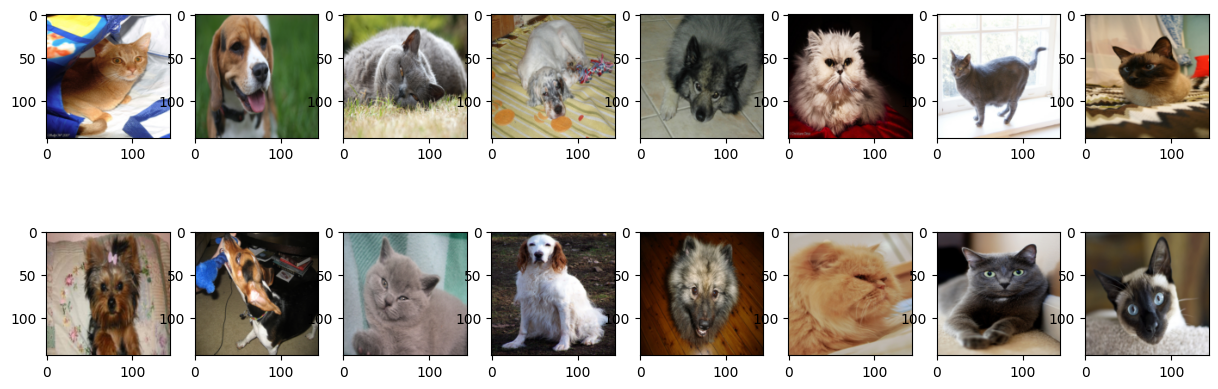

In [6]:
show_images(dataset)

Applying Patchification :

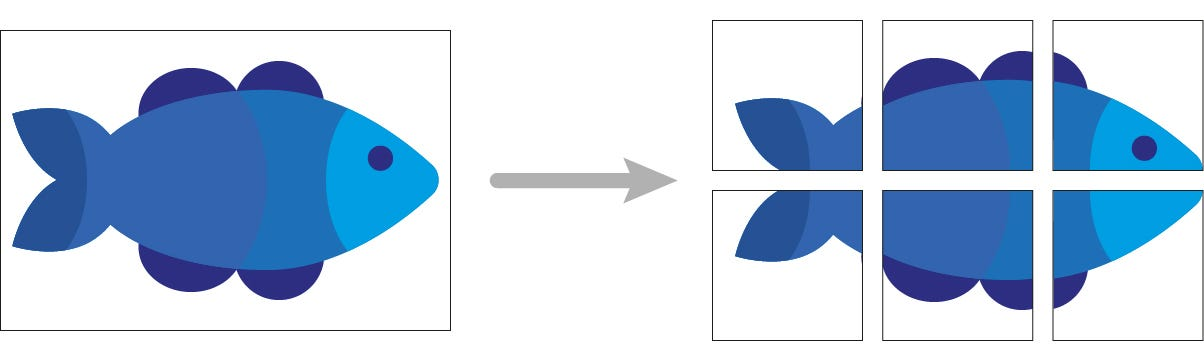


An illustration of the Patchification Process.
(Ref : [URL](https://www.google.com/url?sa=i&url=https%3A%2F%2Flevelup.gitconnected.com%2Fhow-to-split-an-image-into-patches-with-python-e1cf42cf4f77&psig=AOvVaw3Q2QURtCJyD3Wj-9QFWjO7&ust=1732684176855000&source=images&cd=vfe&opi=89978449&ved=0CBcQjhxqFwoTCNiP-N6d-YkDFQAAAAAdAAAAABAJ))

In [7]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels = 3, patch_size = 8, emb_size = 128):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x

The initial Image is of size (1, 3, 144, 144) i.e, 3 colour channels and imagesz = 144 x 144 px.

The result is 324 patches of size 128.

In [8]:
sample_datapoint = torch.unsqueeze(dataset[0][0], 0)
print("Initial shape: ", sample_datapoint.shape)
embedding = PatchEmbedding()(sample_datapoint)
print("Patches shape: ", embedding.shape)

Initial shape:  torch.Size([1, 3, 144, 144])
Patches shape:  torch.Size([1, 324, 128])


# **2. Defining the ViT model :**

The Encoding Layer of the Transformer (ViT)

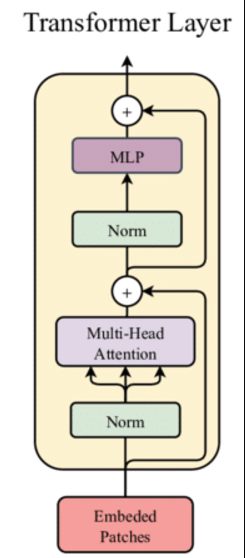

Ref : [Research Gate](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.researchgate.net%2Ffigure%2FTransformer-based-strong-baseline-framework-Output-cls-token-marked-with-is-served_fig1_358144303&psig=AOvVaw3Y02AVwrbs0Kw930AaQXH_&ust=1732686390432000&source=images&cd=vfe&opi=89978449&ved=0CBcQjhxqFwoTCICwv_ml-YkDFQAAAAAdAAAAABAI)

i) Implementing the Multi Head Attention Block :

In [9]:
from einops import rearrange

class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        super().__init__()
        self.n_heads = n_heads
        self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                               num_heads=n_heads,
                                               dropout=dropout) # Using the inbuilt MHA of PyTorch
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

    def forward(self, x):
        q = self.q(x) # Queries
        k = self.k(x) # Keys
        v = self.v(x) # Values
        attn_output, attn_output_weights = self.att(q, k, v)
        return attn_output

In [10]:
Attention(dim=128, n_heads=4, dropout=0.)(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

ii) Implementing the Normalization Block (LayerNorm) :

In [11]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [12]:
norm = PreNorm(128, Attention(dim=128, n_heads=4, dropout=0.))
norm(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

The PreNorm function applies LayerNorm right before calling the Attention Function.

Layer Norm vs Batch Norm :

In Batch Normalization, the Batchsize (N) affects the output, but that is not the case in Layer Normalization.

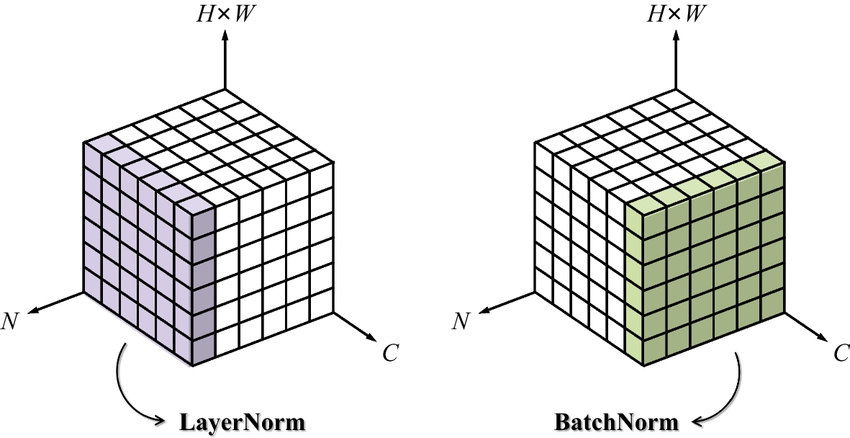


Ref : [ResearchGate](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.researchgate.net%2Ffigure%2FDifference-between-layer-normalization-and-batch-normalization_fig3_375957028&psig=AOvVaw1cnFG1yqQe5iQ7NMmOD48O&ust=1732686938874000&source=images&cd=vfe&opi=89978449&ved=0CBcQjhxqFwoTCIj4jYCo-YkDFQAAAAAdAAAAABAR)

iii) Feed Forward Layer :

In [13]:
class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
ff = FeedForward(dim=128, hidden_dim=256)
ff(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

iv) Residual Layer :

Helps avoid Vanishing Gradients

In [14]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [15]:
residual_att = ResidualAdd(Attention(dim=128, n_heads=4, dropout=0.))
residual_att(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

v) Main Model :

In [16]:
from einops import repeat

class ViT(nn.Module):
    def __init__(self, ch=3, img_size=144, patch_size=4, emb_dim=32,
                n_layers=6, out_dim=37, dropout=0.1, heads=2):
        super(ViT, self).__init__()

        # Attributes
        self.channels = ch
        self.height = img_size
        self.width = img_size
        self.patch_size = patch_size
        self.n_layers = n_layers

        # Patching
        self.patch_embedding = PatchEmbedding(in_channels=ch,
                                              patch_size=patch_size,
                                              emb_size=emb_dim)
        # Learnable params
        num_patches = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

        # Transformer Encoder
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential(
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads = heads, dropout = dropout))),
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout = dropout))))
            self.layers.append(transformer_block)

        # Classification head
        self.head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim))


    def forward(self, img):
        # Get patch embedding vectors
        x = self.patch_embedding(img)
        b, n, _ = x.shape

        # Add cls token to inputs
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        # Transformer layers
        for i in range(self.n_layers):
            x = self.layers[i](x)

        # Output based on classification token
        return self.head(x[:, 0, :])

In [17]:
model = ViT()
print(model)
model(torch.ones((1, 3, 144, 144)))

ViT(
  (patch_embedding): PatchEmbedding(
    (projection): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
      (1): Linear(in_features=48, out_features=32, bias=True)
    )
  )
  (layers): ModuleList(
    (0-5): 6 x Sequential(
      (0): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (att): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (q): Linear(in_features=32, out_features=32, bias=True)
            (k): Linear(in_features=32, out_features=32, bias=True)
            (v): Linear(in_features=32, out_features=32, bias=True)
          )
        )
      )
      (1): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (0): Linear(in_features=32, out_featu

tensor([[-0.4880, -0.8512, -1.0318, -0.3233, -0.1223,  0.2405,  0.0957, -0.1500,
         -1.2869,  0.8173,  1.0156,  0.3023, -0.6333, -0.9165,  0.2439, -0.1152,
          0.0598, -0.0785, -0.0806,  0.4511, -0.4939,  1.2658, -0.1342,  1.1907,
          0.3530,  0.4778, -0.5296, -0.3607,  0.2487,  0.1378, -0.9505, -0.6290,
          0.4651,  0.5980, -0.0490,  0.0534,  0.4244]],
       grad_fn=<AddmmBackward0>)

# **3. Training the ViT :**

In [18]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_split = int(0.8 * len(dataset))
train, test = random_split(dataset, [train_split, len(dataset) - train_split])

train_dataloader = DataLoader(train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test, batch_size=32, shuffle=True)

In [22]:
import torch.optim as optim
import numpy as np

device = "cpu"
model = ViT().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    epoch_losses = []
    model.train()
    for step, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    if epoch % 5 == 0:
        print(f">>> Epoch {epoch} train loss: ", np.mean(epoch_losses))
        epoch_losses = []
        # Something was strange when using this?
        # model.eval()
        for step, (inputs, labels) in enumerate(test_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_losses.append(loss.item())
        print(f">>> Epoch {epoch} test loss: ", np.mean(epoch_losses))

>>> Epoch 0 train loss:  3.6578241534855054
>>> Epoch 0 test loss:  3.640817942826644
>>> Epoch 5 train loss:  3.625280875226726
>>> Epoch 5 test loss:  3.6321528372557266


In [23]:
inputs, labels = next(iter(test_dataloader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)

print("Predicted classes", outputs.argmax(-1))
print("Actual classes", labels)

Predicted classes tensor([19,  0,  5,  0,  5,  5,  5,  5, 19,  5,  5,  0,  5,  5,  5,  5, 19,  5,
         5,  0,  0,  5,  5,  5,  5, 19, 19,  0,  5,  0,  5,  5])
Actual classes tensor([31, 32, 34, 27, 13, 25, 31,  9, 24,  7,  7,  3, 17, 26, 26,  7, 17, 16,
        20, 30, 21, 21, 33,  2, 26, 11, 27, 29,  3,  7, 13,  1])
